# Basic use demo
This jupyter notebook shows the basic use of the internals.

#### Imports

In [1]:
import textwrap
import tempfile

from pathlib import Path

from file_handling.pipeline_input_handling.pipeline_input_file_manager import PipelineInputFileManager
from pipeline_entities.output.pipeline_component_execution_report import PipelineComponentExecutionReport
from pipeline_entities.pipeline_configuration.dataclasses.pipeline_configuration_data import PipelineConfigurationData
from file_handling.pipeline_configuration_handling.pipeline_configuration_file_manager import \
    PipelineConfigurationFileManager
from pipeline_entities.pipeline_configuration.dataclasses.pipeline_configuration import PipelineConfiguration
from pipeline_entities.pipeline_input.pipeline_input import PipelineInput
from pipeline_entities.pipeline_input.pipeline_input_data import PipelineInputData
from pipeline_entities.pipeline.pipeline import Pipeline
from pipeline_entities.pipeline_builder.pipeline_builder import PipelineBuilder
from pipeline_entities.pipeline_manager.pipeline_manager import PipelineManager
from setup_manager.internal_logic_setup_manager import InternalLogicSetupManager

#### Setup

In [2]:
InternalLogicSetupManager.setup()

#### Pipeline configuration
A pipeline configuration defines the structure of a pipeline. Pipeline configurations are loaded from .ini files.
We are using a temporary file to make things easier for this demo.
The .ini content must contain the keys 'supported_program_version' with a value of the type 'packaging.Version' and 'components' with a value of the type 'Tree[str]'.
Values can be written over multiple lines by ending a line with the known '\\'.
We are using the following .ini content:

In [3]:
pipeline_configuration_file_content: bytes = textwrap.dedent("""\
    name="DemoPipeline"
    supported_program_version=Version(\"1.0.0\")
    components=DirectionalAcyclicGraph(\"\"\"
        0=Base Input
        1=Equidistant Node Generator
            predecessors=["0"]
        2=Function Expression Input
            predecessors=["1"]
        3=Interpolation Values Evaluator
            predecessors=["2"]
        4=Aitken Neville Interpolation
            predecessors=["3"]
        5=Newton Interpolation
            predecessors=["3"]
        6=Barycentric1 Interpolation
            predecessors=["3"]
        7=Barycentric2 Interpolation
            predecessors=["3"]
        8=Interpolant Plotter
            predecessors=["4","5","6","7"]
        \"\"\")
    extra_value=True
    """).encode("utf-8")

The pipeline configure has the name 'DemoPipeline', supports the program version 1.0.0 and has an additional entry with the key 'extra_value'.
It's most import entry are the components specified by the matching key named 'components'. Components are arranged in a tree.
The tree structure defines the order of component execution later on.
For easier use, the components are specified through their respective ids (e.g. the BaseInputPipelineComponent has the id 'BaseInput').


After defining the .ini file content, we write the content into a temporary file:

In [4]:
temp_dir = tempfile.TemporaryDirectory()
temp_pipeline_configuration_file = Path(temp_dir.name + "/pipeline_configuration.ini")

with open(temp_pipeline_configuration_file, "wb") as f:
    f.write(pipeline_configuration_file_content)

print(temp_dir.name)

C:\Users\janni\AppData\Local\Temp\tmpaj2fbc3z


With a .ini configuration file, we can start to read in the pipeline configuration into internal structures using the static class 'PipelineConfigurationManager'.
The operation 'load_from_file(path: Path)' reads in a .ini file and parses the input into an instance of the dataclass 'PipelineConfigurationData'.
Instances of this dataclass store the individual entries of a pipeline configuration .ini file as raw strings.
In particular, the values of entries are not evaluated (i.e. 'supported_program_version=Version("1.0.0")' will be stored the string "Version("1.0.0")" and not as an instance of the type 'packaging.Version').

In [5]:
pipeline_configuration_data: PipelineConfigurationData = PipelineConfigurationFileManager.load_from_file(temp_pipeline_configuration_file)

print(pipeline_configuration_data)

PipelineConfigurationData(name='"DemoPipeline"', supported_program_version='Version("1.0.0")', components='DirectionalAcyclicGraph("""\n0=Base Input\n1=Equidistant Node Generator\n    predecessors=["0"]\n2=Function Expression Input\n    predecessors=["1"]\n3=Interpolation Values Evaluator\n    predecessors=["2"]\n4=Aitken Neville Interpolation\n    predecessors=["3"]\n5=Newton Interpolation\n    predecessors=["3"]\n6=Barycentric1 Interpolation\n    predecessors=["3"]\n7=Barycentric2 Interpolation\n    predecessors=["3"]\n8=Interpolant Plotter\n    predecessors=["4","5","6","7"]\n""")', additional_values={'extra_value': 'True'})


The last missing part is the parsing of the values. This can be conveniently done by simply instantiating an instance of the class 'PipelineConfiguration' using our pipeline_configuration_data.
Furthermore, the class 'PipelineConfiguration' will automatically check the types of all values and throw exceptions if given an entry with a key of wrong type (e.g. name is an int instead of a str).

In [6]:
pipeline_configuration: PipelineConfiguration = PipelineConfiguration(pipeline_configuration_data)

print(pipeline_configuration)

PipelineConfiguration(name='DemoPipeline', supported_program_version=<Version('1.0.0')>, components=<data_structures.directed_acyclic_graph.directional_acyclic_graph.DirectionalAcyclicGraph object at 0x000002B42BAA42D0>, additional_values={'extra_value': True})


#### PipelineInput
A pipeline input contains all the data used as input when executing the pipeline.
The pipeline input works very similarly to the pipeline configuration.
Required are the keys 'data_type' with a value of type 'type', 'node_count' with an int value and 'interpolation_interval' with a jax.numpy.ndarray of shape '(2,)' as the value.

In [7]:
pipeline_input_file_content: bytes = textwrap.dedent("""\
    name="TestPipeline"
    data_type=jax.numpy.float32
    node_count=36
    interpolation_interval=jax.numpy.array([-1, 1])
    function_expression="sin(10*x)"
    piecewise_function_expressions=[((0,1), 'x'), ((1,2), 'x**2')]
    sympy_function_expression_simplification=True
    function_callable=lambda x: x**2 + 3
    function_values=jax.numpy.array([0.0, 1.0, 4.0, 9.0, 16.0])
    §secret_token="abc123"
    extra_value=[1, 2, 3]
    """).encode("utf-8")

We write the content into a temporary file:

In [8]:
temp_pipeline_input_file = Path(temp_dir.name + "/pipeline_input.ini")

with open(temp_pipeline_input_file, "wb") as f:
    f.write(pipeline_input_file_content)

Similiar to before, we can load the .ini file into an instance of the dataclass 'PipelineInputData' using the method 'load_from_file(path: Path)' from the static class 'PipelineInputFileManager'.

In [9]:
pipeline_input_data: PipelineInputData = PipelineInputFileManager.load_from_file(temp_pipeline_input_file)

print(pipeline_input_data)

PipelineInputData(name='"TestPipeline"', data_type='jax.numpy.float32', node_count='36', interpolation_interval='jax.numpy.array([-1, 1])', function_expression='"sin(10*x)"', piecewise_function_expression=None, sympy_function_expression_simplification='True', function_callable='lambda x: x**2 + 3', interpolation_values=None, additional_directly_injected_values={'secret_token': '"abc123"'}, additional_values={'piecewise_function_expressions': "[((0,1), 'x'), ((1,2), 'x**2')]", 'function_values': 'jax.numpy.array([0.0, 1.0, 4.0, 9.0, 16.0])', 'extra_value': '[1, 2, 3]'})


We parse the 'pipeline_input_data' by initializing an instance of the class 'PipelineInput':

In [10]:
pipeline_input: PipelineInput = PipelineInput(pipeline_input_data)

print(pipeline_input)

PipelineInput(name='TestPipeline', data_type='<class 'jax.numpy.float32'>', node_count='36', interpolation_interval='[-1  1]', function_expression='sin(10*x)', piecewise_function_expressions='None', sympy_function_expression_simplification='True', function_callable='<function <lambda> at 0x000002B42BB74860>', interpolation_values='None', additional_directly_injected_values='{'secret_token': 'abc123'}', additional_values='{'piecewise_function_expressions': [((0, 1), 'x'), ((1, 2), 'x**2')], 'function_values': Array([ 0.,  1.,  4.,  9., 16.], dtype=float32), 'extra_value': [1, 2, 3]}')


#### Pipeline building
Using the just created 'PipelineInput' and 'PipelineConfiguration' instances, we can assemble a pipeline:

In [11]:
pipeline: Pipeline = PipelineBuilder.build(pipeline_configuration, pipeline_input)

#### Pipeline execution
Instances of the class 'PipelineManager' are responsible for the execution of pipelines.
We start of by initializing a 'PipelineManager' with our pipeline.

In [12]:
pipeline_manager: PipelineManager = PipelineManager(pipeline)

print(pipeline_manager)

PipelineManager(pipeline_configuration_name='DemoPipeline', pipeline_input_name='TestPipeline', amount_of_nodes_left_to_execute=9)


After the initialization, we can execute the complete pipeline by calling 'execute_all()'.

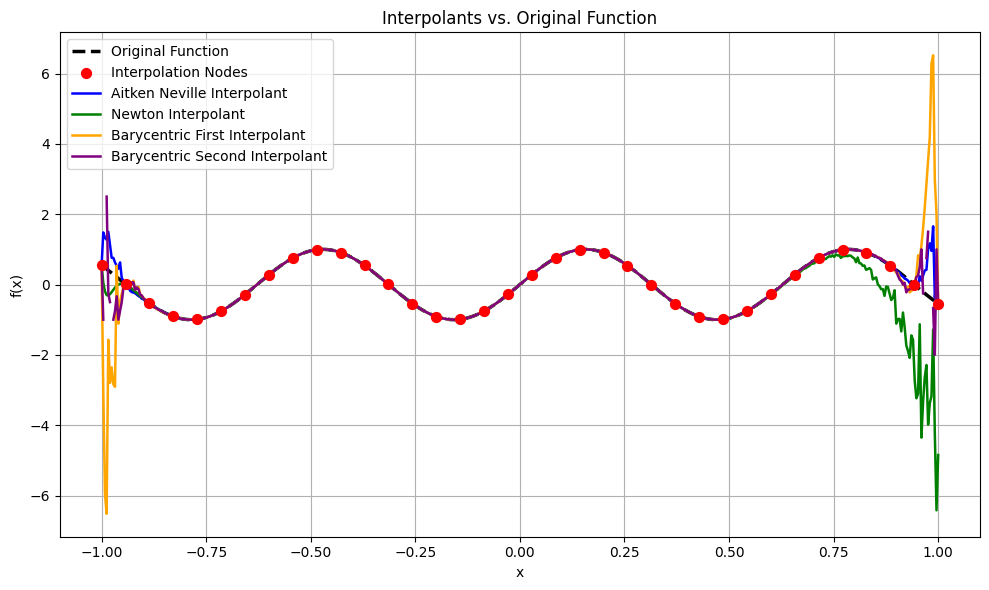

###### Report from node 0 (base input) ######
PipelineComponentExecutionReport(component_instantiation_info=PipelineComponentInstantiationInfo(component_name='0', component=PipelineComponentInfo(component_id='base input', component_type=<class 'pipeline_entities.components.abstracts.input_pipeline_component.InputPipelineComponent'>, component_class=<class 'pipeline_entities.components.default_components.default_input_components.base_input_pipeline_component.BaseInputPipelineComponent'>, component_meta_info=ComponentMetaInfo(attributes_modifying={'data_type', 'node_count', 'interpolation_interval'}, dynamic_constraints=[], static_constraints=[], allow_additional_value_modifications_outside_specification=True)), component_specific_arguments={}), component_output=PipelineData(data_type=<class 'jax.numpy.float32'>, node_count=36, interpolation_interval=Array([-1,  1], dtype=int32), function_callable=None, interpolation_nodes=None, interpolation_values=None, interpolant=None, additional_val

In [13]:
pipeline_manager.execute_all()

for component_name in pipeline_configuration.get_all_component_names():
    report: PipelineComponentExecutionReport = pipeline_manager.get_component_execution_report(component_name)
    component_id: str = report.component_instantiation_info.component.component_id

    print(f"###### Report from node {component_name} ({component_id}) ######")
    print(report)
    print("\n")